In [3]:
import sys
sys.path.append('/Users/mistletoe/量化金融/5-PF')
from backtest.etf_backtesting import *
backtester = Backtesting()
backtester.set_parameters(
    start_date='2020-01-01',
    end_date='2023-12-31',
    frequency_entry='1d',
    frequency_exit='60m')

df_price = backtester.load_data()
symbol = backtester.load_code()
df_price_hl = get_price(symbol, backtester.start_date, backtester.end_date, backtester.frequency_entry)[['low','high']]
df_price_hl


low   high
order_book_id date                    
159766.XSHE   2021-07-23  0.956  0.978
              2021-07-26  0.914  0.970
              2021-07-27  0.903  0.930
              2021-07-28  0.876  0.910
              2021-07-29  0.870  0.886
...                         ...    ...
516970.XSHG   2023-12-25  0.962  0.972
              2023-12-26  0.957  0.966
              2023-12-27  0.953  0.967
              2023-12-28  0.961  0.986
              2023-12-29  0.980  0.987

[13350 rows x 2 columns]

In [4]:
import statsmodels.api as sm

def calculate_beta(group, window):
    beta_series = pd.Series(index=group.index.get_level_values(1))
    for start_index in range(len(group) - window + 1):
        end_index = start_index + window
        window_low = group['low'].iloc[start_index:end_index]
        window_high = group['high'].iloc[start_index:end_index]
        if not window_low.isnull().any() and not window_high.isnull().any():
            X = sm.add_constant(window_low.values) 
            model = sm.OLS(window_high.values, X).fit()
            beta = model.params[1]  # 获取beta值
            beta_series.iloc[end_index - 1] = beta  # 将beta值存储在相应的日期
    return beta_series
N = 20

beta_df = pd.DataFrame(index=df_price.index)

# 对每个ETF分组，然后应用滚动窗口函数
for etf, group in df_price_hl.groupby(level=0):
    beta_df[etf] = calculate_beta(group, N)
beta_df

,159766.XSHE,159825.XSHE,159870.XSHE,159980.XSHE,159981.XSHE,512010.XSHG,512200.XSHG,512480.XSHG,512660.XSHG,512980.XSHG,513050.XSHG,513360.XSHG,515220.XSHG,515230.XSHG,515790.XSHG,516970.XSHG
date,,,,,,,,,,,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,0.983201,0.989232,0.931671,0.906896,1.047551,1.030940,1.022649,0.908787,0.858774,0.806118,0.608464,0.904816,0.604284,0.932004,0.860685,0.891161
2023-12-26,1.010247,1.042375,0.943866,0.905980,1.027216,1.032614,1.057403,0.894837,0.872702,0.855484,0.678395,0.932698,0.642628,0.943291,0.855085,0.942508
2023-12-27,1.027292,1.060925,0.970086,0.919421,0.993386,1.073407,1.023583,0.910036,0.893052,0.893285,0.678208,0.978669,0.644448,0.981095,0.835059,0.921494


In [8]:
beta_df.to_pickle('beta.pkl')

In [6]:
from sklearn.linear_model import LinearRegression
def calculate_beta(df, window=18):
    if df.shape[0] < window:
        return np.nan
    x = df['low'].values
    y = df['high'].values
    beta = LinearRegression().fit(x.reshape(-1, 1), y).coef_[0]
    return beta

def merge_beta(data):
    data['beta'] = [calculate_beta(df,window=18) for df in data.rolling(18)]
    return data

df_price = df_price.groupby('order_book_id').apply(merge_beta)
df_price

order_book_id        date   open   high    low  close  \
order_book_id                                                               
159507.XSHE   0       159507.XSHE  2023-06-26  1.009  1.020  0.989  0.993   
              1       159507.XSHE  2023-06-27  0.993  1.014  0.990  1.010   
              2       159507.XSHE  2023-06-28  1.008  1.008  0.963  0.983   
              3       159507.XSHE  2023-06-29  0.980  1.004  0.980  1.001   
              4       159507.XSHE  2023-06-30  1.002  1.023  0.995  1.014   
...                           ...         ...    ...    ...    ...    ...   
561320.XSHG   28410   561320.XSHG  2023-12-25  0.824  0.829  0.822  0.829   
              28411   561320.XSHG  2023-12-26  0.832  0.832  0.821  0.821   
              28412   561320.XSHG  2023-12-27  0.821  0.823  0.815  0.818   
              28413   561320.XSHG  2023-12-28  0.818  0.832  0.817  0.829   
              28414   561320.XSHG  2023-12-29  0.829  0.829  0.825  0.828   

                          pct      beta  
order_book_id                            
159507.XSHE   0     -0.030273       NaN  
              1      0.017120       NaN  
              2     -0.026733       NaN  
              3      0.018311       NaN  
              4      0.012987       NaN  
...                       ...       ...  
561320.XSHG   28410 -0.001205  0.954959  
              28411 -0.009650  0.945724  
              28412 -0.003654  0.964459  
              28413  0.013447  0.970770  
              28414 -0.001206  0.965535  

[28415 rows x 8 columns]

In [7]:
df_price = df_price.dropna().reset_index(drop=True)
df_price.head()

,order_book_id,date,open,high,low,close,pct,beta
0,159507.XSHE,2023-07-19,1.008,1.011,0.996,0.997,-0.009930,0.546215
1,159507.XSHE,2023-07-20,0.998,0.998,0.963,0.964,-0.033099,0.560695
2,159507.XSHE,2023-07-21,0.960,0.968,0.952,0.961,-0.003112,0.723037
3,159507.XSHE,2023-07-24,0.955,0.980,0.955,0.967,0.006243,0.818640
4,159507.XSHE,2023-07-25,0.971,0.982,0.966,0.974,0.007239,0.854033


均值：0.939
标准差：0.173
偏度：-0.944
峰度：9.247


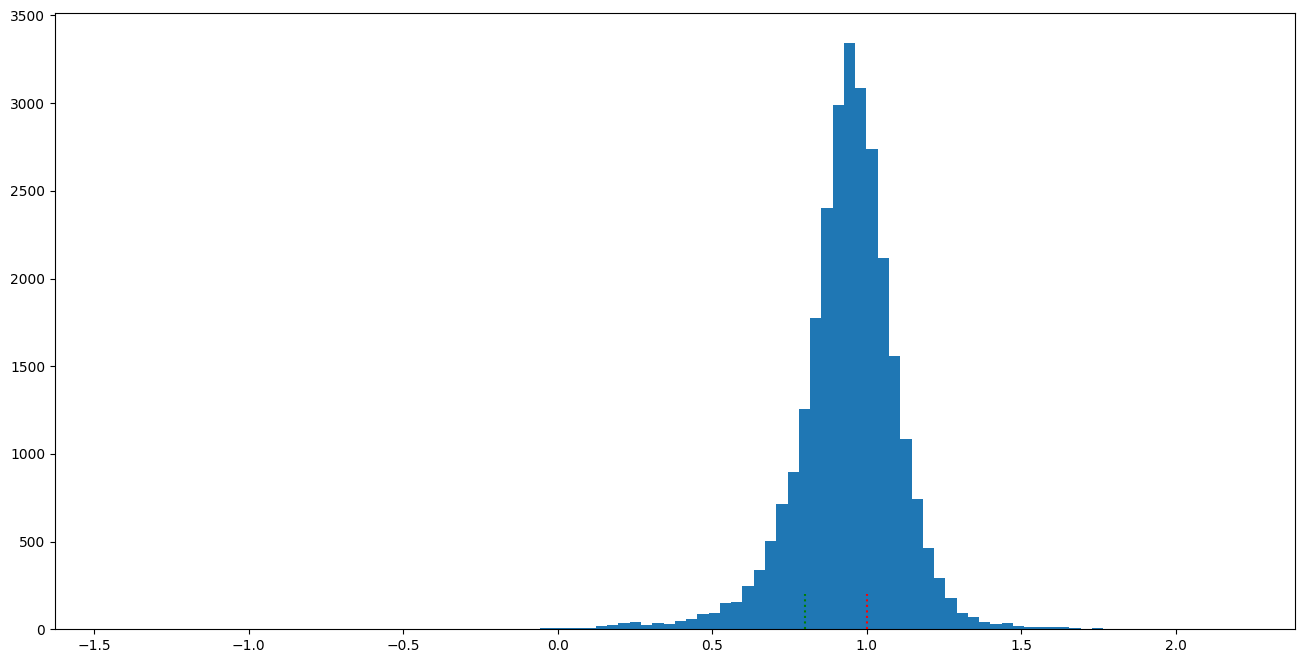

In [8]:
data = df_price.copy()
print('均值：%.3f' %data['beta'].mean())
print('标准差：%.3f' %data['beta'].std())
print('偏度：%.3f' %data['beta'].skew())
print('峰度：%.3f' %data['beta'].kurt())

y = list(range(200))
plt.figure(figsize=(16,8))
plt.hist(data['beta'], bins=100)
plt.plot(len(y)*[0.8], y, color='green', linestyle=':')
plt.plot(len(y)*[1.0], y, color='red', linestyle=':')
plt.show()

In [9]:
stock_counts = data['order_book_id'].value_counts()
max_stock = stock_counts.idxmax()
max_stock


'512010.XSHG'

RSRS斜率量化择时策略的年化收益率：2.00%


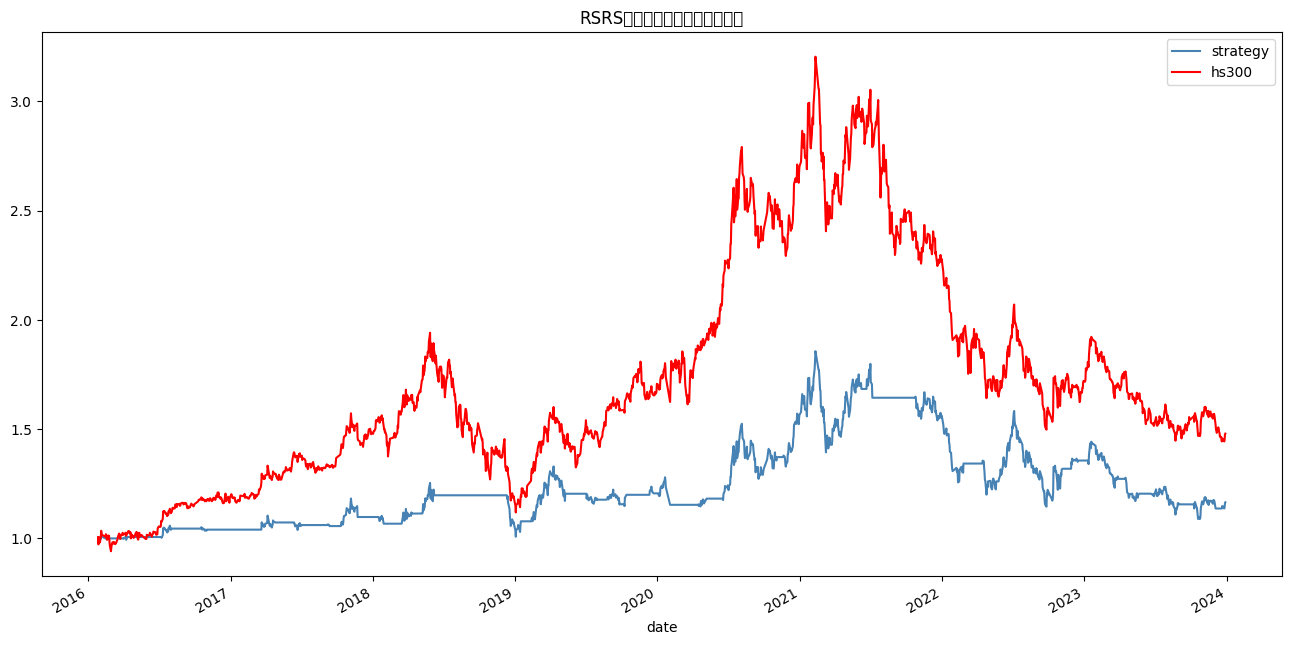

In [10]:
data = data[data['order_book_id'] == '512010.XSHG']
buy_thre = 1.0  
sell_thre = 0.8 
data1 = data.dropna().copy().reset_index(drop=True)

data1['flag'] = 0 
data1['position'] = 0
position = 0 
for i in range(1, data1.shape[0]-1):
    beta = data1.loc[i,'beta']
    if (position == 0) and (beta > buy_thre):
        data1.loc[i,'flag'] = 1
        data1.loc[i+1,'position'] = 1
        position = 1
    elif (position == 1) and (beta < sell_thre): 
        data1.loc[i,'flag'] = -1
        data1.loc[i+1,'position'] = 0     
        position = 0
    else:
        data1.loc[i+1,'position'] = data1.loc[i,'position']     

data1['strategy_pct'] = data1['pct'] * data1['position']

#策略和直接持有到期的净值
data1['strategy'] = (1.0 + data1['strategy_pct']).cumprod()
data1['hs300'] = (1.0 + data1['pct']).cumprod()
# # 粗略计算年化收益率
annual_return = 100 * (pow(data1['strategy'].iloc[-1], 250/data1.shape[0]) - 1.0)
print('RSRS斜率量化择时策略的年化收益率：%.2f%%' %annual_return)

#将索引从字符串转换为日期格式，方便展示
data1.index = pd.to_datetime(data1['date'])
ax = data1[['strategy','hs300']].plot(figsize=(16,8), color=['SteelBlue','Red'],
                                      title='RSRS斜率量化指数择时策略净值')
plt.show()

RSRS标准分量化择时策略的年化收益率:1.27%


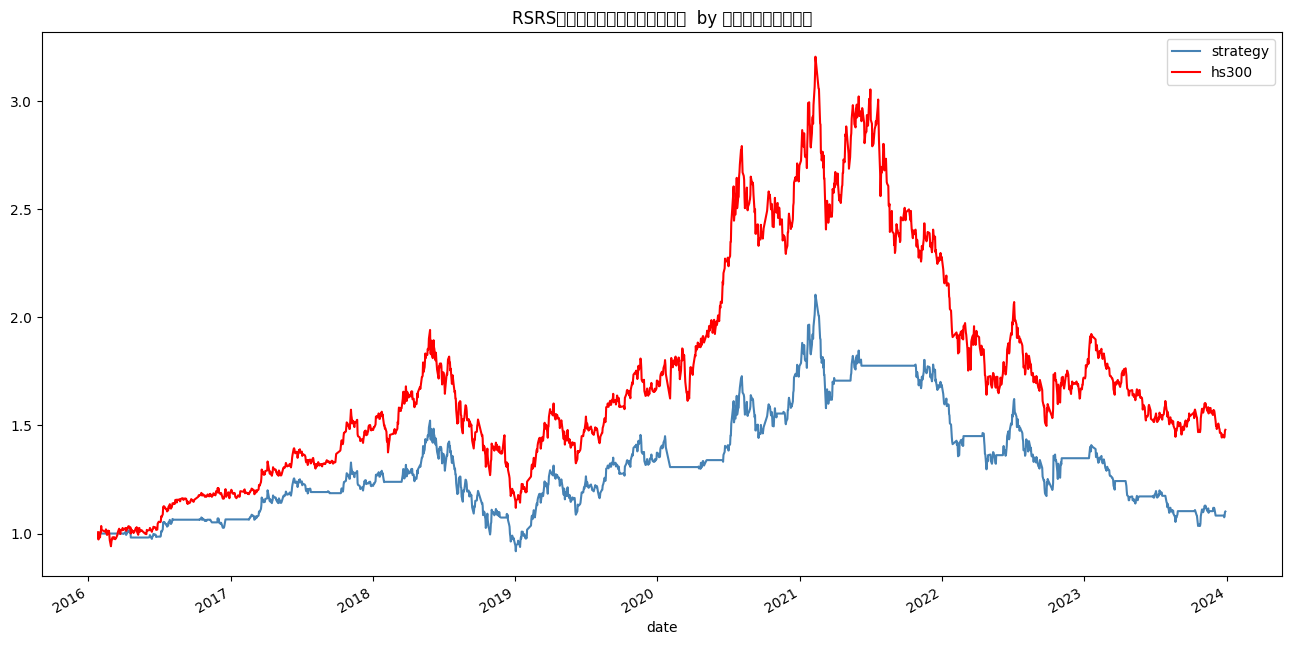

In [35]:
# RSRS标准分
M = 600 
buy_thre = 0.7 
sell_thre = -0.7
data2 = data.dropna().copy().reset_index(drop=True)
data2['std_score'] = (data2['beta'] - data2['beta'].rolling(M, min_periods=20).mean())/data2['beta'].rolling(M, min_periods=20).std()

data2['flag'] = 0
data2['position'] = 0 
position = 0 
for i in range(1, data2.shape[0]-1):
    std_score = data2.loc[i,'std_score']
    if (position == 0) and (std_score > buy_thre):
        data2.loc[i,'flag'] = 1
        data2.loc[i+1,'position'] = 1
        position = 1
    elif (position == 1) and (std_score < sell_thre): 
        data2.loc[i,'flag'] = -1
        data2.loc[i+1,'position'] = 0     
        position = 0
    else:
        data2.loc[i+1,'position'] = data2.loc[i,'position']     

data2['strategy_pct'] = data2['pct'] * data2['position']
data2['strategy'] = (1.0 + data2['strategy_pct']).cumprod()
data2['hs300'] = (1.0 + data2['pct']).cumprod()

annual_return = 100 * (pow(data2['strategy'].iloc[-1], 250/data2.shape[0]) - 1.0)
print('RSRS标准分量化择时策略的年化收益率:%.2f%%' %annual_return)

data2.index = pd.to_datetime(data2['date'])
ax = data2[['strategy','hs300']].plot(figsize=(16,8), color=['SteelBlue','Red'],
                                      title='RSRS标准分量化指数择时策略净值')
plt.show()

In [86]:
data2

,order_book_id,date,open,high,low,close,pct,beta,std_score,flag,position,strategy_pct,strategy,hs300
date,,,,,,,,,,,,,,
2016-01-27,512010.XSHG,2016-01-27,0.2645,0.2800,0.2645,0.2795,0.006120,0.904720,NaN,0,0,0.000000,1.000000,1.006120
2016-01-28,512010.XSHG,2016-01-28,0.2800,0.2800,0.2662,0.2702,-0.033274,0.938989,NaN,0,0,-0.000000,1.000000,0.972642
2016-01-29,512010.XSHG,2016-01-29,0.2745,0.2778,0.2660,0.2775,0.027017,0.945081,NaN,0,0,0.000000,1.000000,0.998920
2016-02-01,512010.XSHG,2016-02-01,0.2900,0.2900,0.2652,0.2728,-0.016937,0.960825,NaN,0,0,-0.000000,1.000000,0.982001
2016-02-02,512010.XSHG,2016-02-02,0.2850,0.2850,0.2700,0.2800,0.026393,1.185944,NaN,0,0,0.000000,1.000000,1.007919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,512010.XSHG,2023-12-25,0.4020,0.4060,0.4010,0.4040,0.002481,1.054289,0.909202,1,0,0.000000,1.083065,1.454284
2023-12-26,512010.XSHG,2023-12-26,0.4040,0.4040,0.3980,0.4010,-0.007426,1.120236,1.421582,0,1,-0.007426,1.075022,1.443485
2023-12-27,512010.XSHG,2023-12-27,0.4010,0.4030,0.3980,0.4030,0.004988,1.114443,1.371606,0,1,0.004988,1.080384,1.450684


* 优化标准分策略

以此降低绝对值很大，但实际拟合效果很差的标准分对策略的影响。

大熊市中每日跌幅十分巨大（绝对值很大）但是实际拟合效果也很差

In [92]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
def calculate_beta_r2(df, window=18):
    if df.shape[0] < window:
        return np.nan,np.nan
    x = df['low'].values
    y = df['high'].values
    lr = LinearRegression().fit(x.reshape(-1, 1), y)
    y_pred = lr.predict(x.reshape(-1, 1))
    r2 = r2_score(y, y_pred)
    beta = lr.coef_[0]
    return beta,r2

def merge_beta_r2(data):
    tup_list = [calculate_beta_r2(df,window=18) for df in data.rolling(18)]
    data['beta'] = [v[0] for v in tup_list if v is not None] 
    data['r2'] = [v[1] for v in tup_list if v is not None] 
    return data

df_price = df_price.groupby('order_book_id').apply(merge_beta_r2).dropna().reset_index(drop=True)
df_price

,order_book_id,date,open,high,low,close,pct,beta,r2
0,159507.XSHE,2023-07-19,1.008,1.011,0.996,0.997,-0.009930,0.546215,0.551565
1,159507.XSHE,2023-07-20,0.998,0.998,0.963,0.964,-0.033099,0.560695,0.605407
2,159507.XSHE,2023-07-21,0.960,0.968,0.952,0.961,-0.003112,0.723037,0.668283
3,159507.XSHE,2023-07-24,0.955,0.980,0.955,0.967,0.006243,0.818640,0.756082
4,159507.XSHE,2023-07-25,0.971,0.982,0.966,0.974,0.007239,0.854033,0.760468
...,...,...,...,...,...,...,...,...,...
27968,561320.XSHG,2023-12-25,0.824,0.829,0.822,0.829,-0.001205,0.954959,0.901286
27969,561320.XSHG,2023-12-26,0.832,0.832,0.821,0.821,-0.009650,0.945724,0.899133
27970,561320.XSHG,2023-12-27,0.821,0.823,0.815,0.818,-0.003654,0.964459,0.906135
27971,561320.XSHG,2023-12-28,0.818,0.832,0.817,0.829,0.013447,0.970770,0.892063


In [93]:
M = 600 
data3 = df_price.dropna().copy().reset_index(drop=True)
data3['std_score'] = (data3['beta'] - data3['beta'].rolling(M, min_periods=20).mean())/data3['beta'].rolling(M, min_periods=20).std()
data3['mdf_std_score'] = data3['r2'] * data3['std_score']
data3.tail(20)

,order_book_id,date,open,high,low,close,pct,beta,r2,std_score,mdf_std_score
27953,561320.XSHG,2023-12-04,0.857,0.862,0.857,0.857,0.001168,0.937678,0.833915,-0.061473,-0.051263
27954,561320.XSHG,2023-12-05,0.858,0.858,0.845,0.848,-0.010502,0.856943,0.781455,-0.635235,-0.496408
27955,561320.XSHG,2023-12-06,0.840,0.849,0.837,0.845,-0.003538,0.790666,0.765065,-1.104435,-0.844964
27956,561320.XSHG,2023-12-07,0.843,0.847,0.839,0.846,0.001183,0.816850,0.777620,-0.914794,-0.711362
27957,561320.XSHG,2023-12-08,0.848,0.856,0.848,0.855,0.010638,0.790594,0.773597,-1.098449,-0.849756
27958,561320.XSHG,2023-12-11,0.857,0.857,0.836,0.854,-0.001170,0.596491,0.610701,-2.463936,-1.504728
27959,561320.XSHG,2023-12-12,0.853,0.858,0.851,0.856,0.002342,0.591292,0.607156,-2.483413,-1.507819
27960,561320.XSHG,2023-12-13,0.851,0.851,0.843,0.843,-0.015187,0.610221,0.661279,-2.335024,-1.544103
27961,561320.XSHG,2023-12-14,0.848,0.848,0.840,0.842,-0.001186,0.657879,0.691907,-1.990135,-1.376989
27962,561320.XSHG,2023-12-15,0.844,0.844,0.834,0.835,-0.008314,0.703687,0.734166,-1.662410,-1.220485


均值：-0.0119
标准差：1.0520
偏度：-0.4526
峰度：3.0868


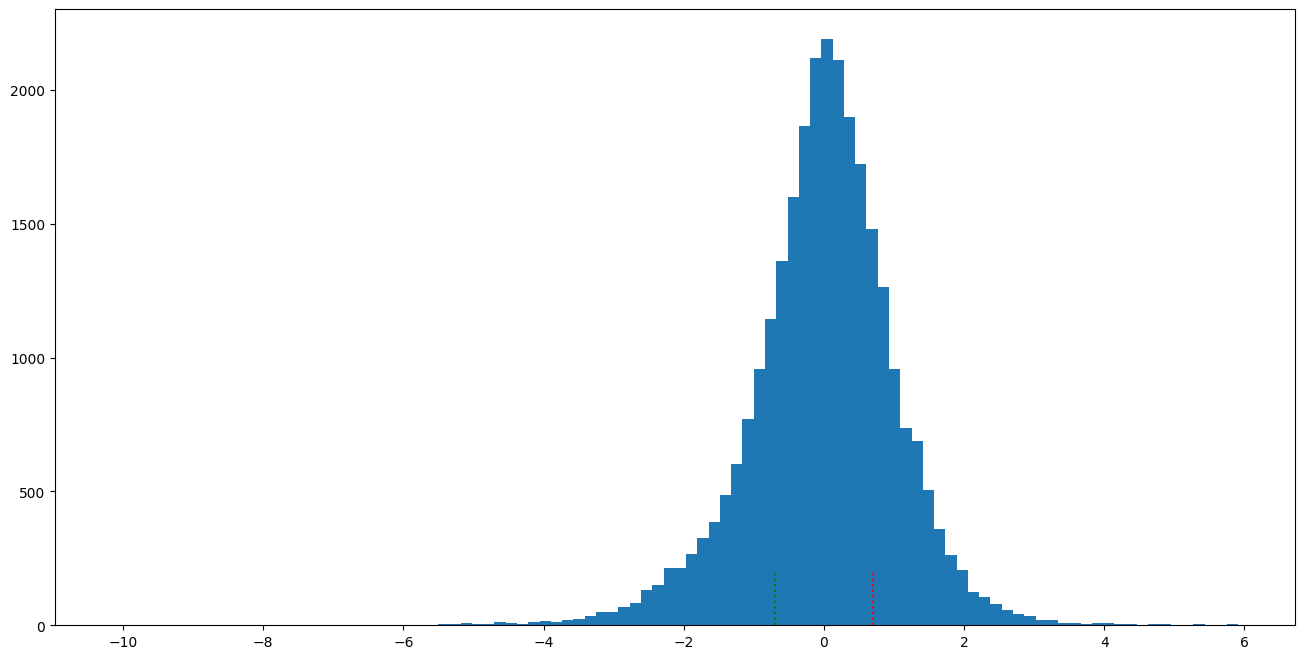

In [94]:
print('均值：%.4f' %data3['std_score'].mean())
print('标准差：%.4f' %data3['std_score'].std())
print('偏度：%.4f' %data3['std_score'].skew())
print('峰度：%.4f' %data3['std_score'].kurt())

y = list(range(200))
plt.figure(figsize=(16,8))
plt.hist(data3['std_score'], bins=100)
plt.plot(len(y)*[-0.7], y, color='green', linestyle=':')
plt.plot(len(y)*[0.7], y, color='red', linestyle=':')
plt.show()

RSRS修正标准分量化择时策略的年化收益率：5.55%


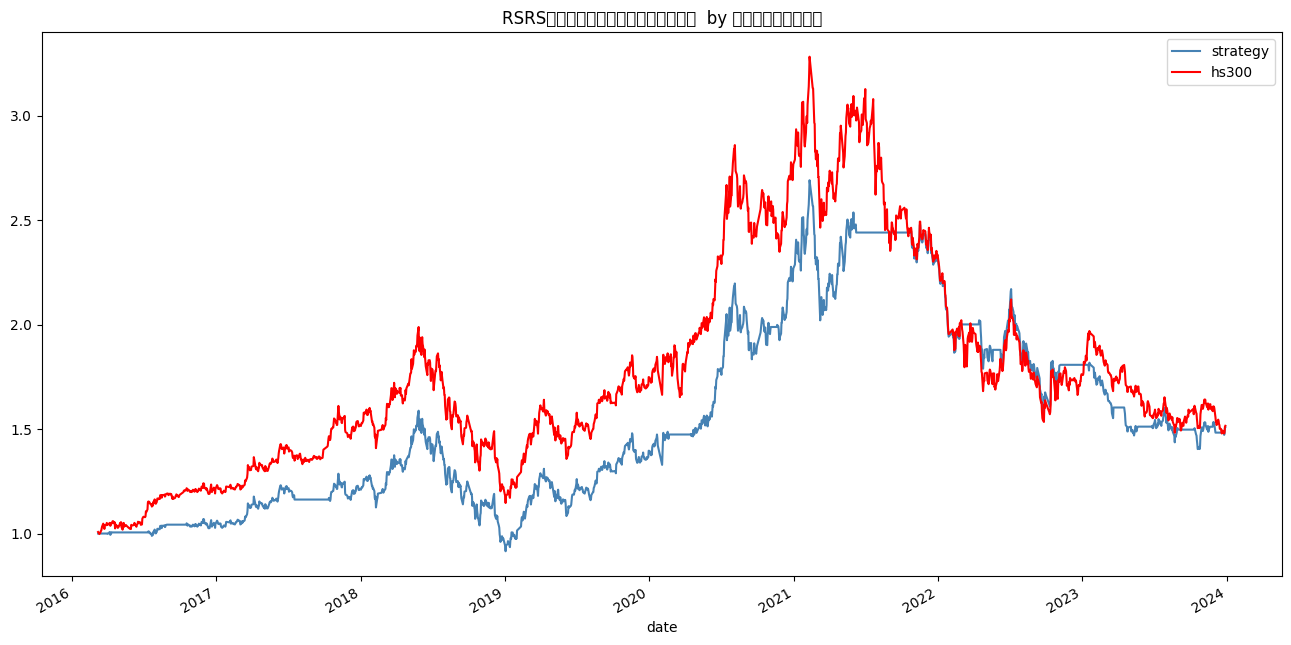

In [84]:
buy_thre = 0.7 # 买入阈值
sell_thre = -0.7 # 卖出阈值
data3 = data3[data3['order_book_id'] == '512010.XSHG']
data3['flag'] = 0 
data3['position'] = 0 
position = 0 
for i in range(1, data3.shape[0]-1):
    mdf_std_score = data3.loc[i,'mdf_std_score']
    if (position == 0) and (mdf_std_score > buy_thre):
        # 若之前无持仓，上穿买入阈值则买入
        data3.loc[i,'flag'] = 1
        data3.loc[i+1,'position'] = 1
        position = 1
    elif (position == 1) and (mdf_std_score < sell_thre): 
        # 若之前有持仓，下穿卖出阈值则卖出
        data3.loc[i,'flag'] = -1
        data3.loc[i+1,'position'] = 0     
        position = 0
    else:
        # 不触发阈值，则保持原有持仓状态
        data3.loc[i+1,'position'] = data3.loc[i,'position']     

data3['strategy_pct'] = data3['pct'] * data3['position']

data3['strategy'] = (1.0 + data3['strategy_pct']).cumprod()
data3['hs300'] = (1.0 + data3['pct']).cumprod()

# 粗略计算年化收益率
annual_return = 100 * (pow(data3['strategy'].iloc[-1], 250/data3.shape[0]) - 1.0)
print('RSRS修正标准分量化择时策略的年化收益率：%.2f%%' %annual_return)

#将索引从字符串转换为日期格式，方便展示
data3.index = pd.to_datetime(data3['date'])
ax = data3[['strategy','hs300']].plot(figsize=(16,8), color=['SteelBlue','Red'],
                                      title='RSRS修正标准分量化指数择时策略净值')
plt.show()

In [62]:
data3.reset_index(inplace=True)

In [79]:
data3 = data3[data3['order_book_id'] == '512010.XSHG']

In [82]:
data3.reset_index(drop=True, inplace=True)

In [83]:
data3

,order_book_id,date,open,high,low,close,pct,beta,r2,std_score,mdf_std_score
0,512010.XSHG,2016-03-08,0.2748,0.2748,0.2688,0.2732,0.007375,0.562874,0.420030,-2.929094,-1.230307
1,512010.XSHG,2016-03-09,0.2680,0.2738,0.2670,0.2725,-0.002562,0.560978,0.402221,-2.919496,-1.174282
2,512010.XSHG,2016-03-10,0.2725,0.2725,0.2690,0.2722,-0.001101,0.559045,0.380540,-2.910730,-1.107648
3,512010.XSHG,2016-03-11,0.2700,0.2705,0.2700,0.2705,-0.006245,0.533932,0.314030,-3.089063,-0.970059
4,512010.XSHG,2016-03-14,0.2725,0.2795,0.2725,0.2728,0.008503,0.542294,0.291855,-2.993324,-0.873617
...,...,...,...,...,...,...,...,...,...,...,...
1899,512010.XSHG,2023-12-25,0.4020,0.4060,0.4010,0.4040,0.002481,1.054289,0.958772,0.909202,0.871717
1900,512010.XSHG,2023-12-26,0.4040,0.4040,0.3980,0.4010,-0.007426,1.120236,0.960369,1.421582,1.365243
1901,512010.XSHG,2023-12-27,0.4010,0.4030,0.3980,0.4030,0.004988,1.114443,0.945843,1.371606,1.297324
1902,512010.XSHG,2023-12-28,0.4020,0.4110,0.4000,0.4100,0.017370,1.013333,0.913395,0.576380,0.526463


In [ ]:
data4 # 右侧标准分与未来十天沪深 300 的收益率有尚可的正相关性

In [100]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
def calculate_beta_r2(df, window=16):
    if df.shape[0] < window:
        return np.nan,np.nan
    x = df['low'].values
    y = df['high'].values
    lr = LinearRegression().fit(x.reshape(-1, 1), y)
    y_pred = lr.predict(x.reshape(-1, 1))
    r2 = r2_score(y, y_pred)
    beta = lr.coef_[0]
    return beta,r2

def merge_beta_r2(data):
    tup_list = [calculate_beta_r2(df,window=16) for df in data.rolling(16)]
    data['beta'] = [v[0] for v in tup_list if v is not None] 
    data['r2'] = [v[1] for v in tup_list if v is not None] 
    return data

df_price = df_price.groupby('order_book_id').apply(merge_beta_r2).dropna().reset_index(drop=True)
df_price

,order_book_id,date,open,high,low,close,pct,beta,r2
0,159507.XSHE,2023-07-17,1.009,1.033,1.009,1.023,0.007882,0.578876,0.576673
1,159507.XSHE,2023-07-18,1.021,1.022,1.004,1.007,-0.015640,0.564119,0.589030
2,159507.XSHE,2023-07-19,1.008,1.011,0.996,0.997,-0.009930,0.545639,0.558067
3,159507.XSHE,2023-07-20,0.998,0.998,0.963,0.964,-0.033099,0.614428,0.634179
4,159507.XSHE,2023-07-21,0.960,0.968,0.952,0.961,-0.003112,0.778615,0.710140
...,...,...,...,...,...,...,...,...,...
28020,561320.XSHG,2023-12-25,0.824,0.829,0.822,0.829,-0.001205,0.948598,0.875422
28021,561320.XSHG,2023-12-26,0.832,0.832,0.821,0.821,-0.009650,0.993108,0.874737
28022,561320.XSHG,2023-12-27,0.821,0.823,0.815,0.818,-0.003654,0.987498,0.891556
28023,561320.XSHG,2023-12-28,0.818,0.832,0.817,0.829,0.013447,0.937899,0.883859


In [101]:
M = 300 # 观察周期，与前面策略不一样

data4 = df_price.dropna().reset_index(drop=True)
# 计算标准分，如果当前时间长度不够，则使用至少20交易日数据计算
data4['std_score'] = (data4['beta'] - data4['beta'].rolling(M, min_periods=20).mean())/data4['beta'].rolling(M, min_periods=20).std()
data4['mdf_std_score'] = data4['r2'] * data4['std_score']
data4['rsk_std_score'] = data4['beta'] * data4['mdf_std_score']
data4.tail(20)

,order_book_id,date,open,high,low,close,pct,beta,r2,std_score,mdf_std_score,rsk_std_score
28005,561320.XSHG,2023-12-04,0.857,0.862,0.857,0.857,0.001168,0.935360,0.784451,-0.030215,-0.023702,-0.022170
28006,561320.XSHG,2023-12-05,0.858,0.858,0.845,0.848,-0.010502,0.829545,0.608153,-0.684110,-0.416044,-0.345127
28007,561320.XSHG,2023-12-06,0.840,0.849,0.837,0.845,-0.003538,0.716146,0.691169,-1.381794,-0.955054,-0.683958
28008,561320.XSHG,2023-12-07,0.843,0.847,0.839,0.846,0.001183,0.782075,0.770572,-0.977947,-0.753579,-0.589355
28009,561320.XSHG,2023-12-08,0.848,0.856,0.848,0.855,0.010638,0.782075,0.770572,-0.980401,-0.755470,-0.590834
28010,561320.XSHG,2023-12-11,0.857,0.857,0.836,0.854,-0.001170,0.580617,0.649832,-2.211806,-1.437302,-0.834521
28011,561320.XSHG,2023-12-12,0.853,0.858,0.851,0.856,0.002342,0.577927,0.644478,-2.220203,-1.430872,-0.826939
28012,561320.XSHG,2023-12-13,0.851,0.851,0.843,0.843,-0.015187,0.596955,0.633904,-2.136372,-1.354256,-0.808430
28013,561320.XSHG,2023-12-14,0.848,0.848,0.840,0.842,-0.001186,0.646575,0.656397,-1.841058,-1.208465,-0.781364
28014,561320.XSHG,2023-12-15,0.844,0.844,0.834,0.835,-0.008314,0.708823,0.725620,-1.447673,-1.050460,-0.744590


RSRS右偏标准分量化择时策略的年化收益率：7.52%


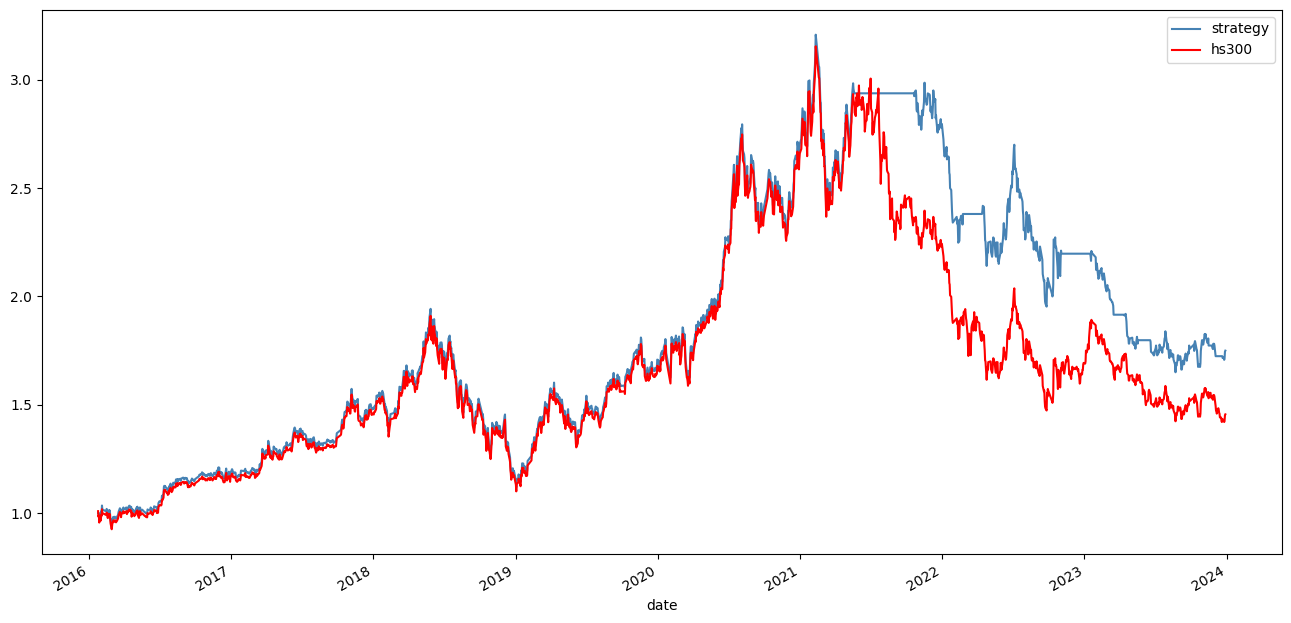

In [105]:
buy_thre = 0.7 
sell_thre = -0.7 
data4 = data4[data4['order_book_id'] == '512010.XSHG']
data4['flag'] = 0
data4['position'] = 0
position = 0 
for i in range(1, data4.shape[0]-1):
    rsk_std_score = data4.loc[i,'rsk_std_score']
    if (position == 0) and (rsk_std_score > buy_thre):
        data4.loc[i,'flag'] = 1
        data4.loc[i+1,'position'] = 1
        position = 1
    elif (position == 1) and (rsk_std_score < sell_thre): 
        data4.loc[i,'flag'] = -1
        data4.loc[i+1,'position'] = 0     
        position = 0
    else:
        data4.loc[i+1,'position'] = data4.loc[i,'position']     

data4['strategy_pct'] = data4['pct'] * data4['position']
data4['strategy'] = (1.0 + data4['strategy_pct']).cumprod()
data4['hs300'] = (1.0 + data4['pct']).cumprod()
annual_return = 100 * (pow(data4['strategy'].iloc[-1], 250/data4.shape[0]) - 1.0)
print('RSRS右偏标准分量化择时策略的年化收益率：%.2f%%' %annual_return)
data4.index = pd.to_datetime(data4['date'])
ax = data4[['strategy','hs300']].plot(figsize=(16,8), color=['SteelBlue','Red'])
plt.show()

* 配合量价数据优化 

    * 左侧开仓预测错误的危害远远大于左侧平仓预测错误
    * 开仓时候加入对目前市场状态的判断，过滤掉左侧开仓即下跌行情的开仓